In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', )))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))

from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.gridspec as gridspec

import seaborn as sns

from config_colors import *
from config_paths import *
from config_plot_params import *
from nwb_io import *

from tabulate import tabulate
from nilearn.plotting import plot_markers

import binning_isolated_from_db as binning

np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.8f}'.format)

# save panels directly to the relevant svg/ subdir
panel_save_dir = Path.cwd().parent.parent / "figure_generation" / "figure_spike_sorting" / "svg"

data_dir = NWB_data_dir

Loaded font name: Helvetica


/home/al/Documents/phd/code/dhv_dataset/plot_code/spike_sorting/binning_isolated_from_db.py:6: UserWarning: Loaded in the copy of the binning functions that lives outside the epiphyte environment! Make sure edits make it into the main function, this is a bad practice sorry.
  warnings.warn("Loaded in the copy of the binning functions that lives outside the epiphyte environment! Make sure edits make it into the main function, this is a bad practice sorry.")


In [115]:
patient_id = 20

path = f"/media/al/Seagate/refractored_data/patient_data/{patient_id}/session_1/sub{patient_id}.nwb"
print(f"  {patient_id}")
io = NWBHDF5IO(path, mode="r")
nwbfile = io.read()


  20


In [ ]:
subdivide = None
small_bin_length = None
bin_length = 1000

pat_list = [14,20,23,28,
            #30,31,33,39,41,42,
            #44,50,52,53,60,61,64,65,66,
              #68,73,83,87,
              ]
#pat_list = [14]

i=0

units_per_channel = []
region_for_channel = []

for patient_id in pat_list:

    path = f"/media/al/Seagate/refractored_data/patient_data/{patient_id}/session_1/sub{patient_id}.nwb"
    print(f"  {patient_id}")
    io = NWBHDF5IO(path, mode="r")
    nwbfile = io.read()

    print("  converting spikes to dataframe..")
    df_units = nwbfile.units.to_dataframe()
    df_units["unit_id"] = np.arange(0, len(df_units))

    df_units.insert(0, "patient_id", [patient_id] * len(df_units), )

    ### calculate firing rate
    movie_edges_all = nwbfile.stimulus["movie_binning_info"].to_dataframe()
    movie_edges = movie_edges_all[movie_edges_all["bin_length"] == bin_length]["edges"].iloc[0]

    spikes = df_units["spike_times"]

    wl = nwbfile.stimulus["cleaned_watchlogs"].to_dataframe()
    patient_rec = wl["neural_recording_time"].to_numpy()
    patient_pts = wl["pts"].to_numpy()

    res = binning.bin_spikes_with_movie_edges(bin_length, spikes, movie_edges, patient_rec, patient_pts, subdivide, small_bin_length)
    
    fr_hz = np.mean(res, axis=1)
    df_units.insert(len(df_units.columns) - 1, "fr_hz", fr_hz)
    ###

    ### grab number of units per channel
    channel_names = nwbfile.ec_electrode_groups.keys()
    nm_total_channels = len(channel_names) * 8

    electrode_df = nwbfile.ec_electrodes.to_dataframe()

    for id, row in electrode_df.iterrows():
        csc_nr = row.csc_nr
        brain_region = row.brain_region

        mask = df_units["csc_nr"] == csc_nr
        filtered_df = df_units[mask]
        nm_units_in_channel = len(filtered_df)

        units_per_channel.append(nm_units_in_channel)
        region_for_channel.append(brain_region)
    ###


    if i == 0:
        df_units_all = df_units.copy()
    else:
        df_units_all = pd.concat([df_units_all, df_units], ignore_index=True)
    
    io.close()
    i += 1



df_units_all = df_units_all[df_units_all["brain_region"] != "I"]
df_units_all = df_units_all[df_units_all["brain_region"] != "T"]
df_units_all["brain_region"] = df_units_all["brain_region"].replace(["AH", "MH", "PH"], "H",)


units_per_channel = np.array(units_per_channel)
region_for_channel = np.array(region_for_channel)

df_channelwise_units = pd.DataFrame({
    "channel_count": units_per_channel,
    "channel_region": region_for_channel, 
})

df_channelwise_units["channel_region"] = df_channelwise_units["channel_region"].replace(["AH", "MH", "PH"], "H",)




  14
*** BINNING STARTS ***
Final res shape: (40, 4726)
*** BINNING ENDS ***

  20
*** BINNING STARTS ***
Final res shape: (83, 4726)
*** BINNING ENDS ***

  23
*** BINNING STARTS ***
Final res shape: (51, 4726)
*** BINNING ENDS ***

  28


KeyboardInterrupt: 

In [176]:
# data processing 

## units per channel
def channelwise_hists_for_a_region(df_channelwise_units, region, bins):
    mask = df_channelwise_units["channel_region"] == region
    region_channels = df_channelwise_units[mask]
    hists, _ = np.histogram(region_channels["channel_count"].to_numpy(), bins)
    return hists

def cdf_regionwise_channels(df_channelwise_units, bins):
    regions = np.unique(df_channelwise_units["channel_region"])
    return {r: apply_cdf(channelwise_hists_for_a_region(df_channelwise_units, r, bins)) for r in regions}

def data_units_per_channel(df_channelwise_units, bins=25):
    hist, bin_edges = np.histogram(df_channelwise_units["channel_count"], bins)

    regions_cdf_dict = cdf_regionwise_channels(df_channelwise_units, bins)
    return hist, bin_edges, regions_cdf_dict


## other metrics/amounts
def filter_df_column_by_region(df_units_all: pd.DataFrame, column: str, region: str, bins: int, log: bool):
    mask = df_units_all["brain_region"] == region
    df_region_restricted = df_units_all[mask]

    nan_mask = ~np.isnan(df_region_restricted[column])
    df_region_data = df_region_restricted[nan_mask]

    if log: 
        data = np.log10(df_region_data[column])
    else:
        data = df_region_data[column].to_numpy()

    hists, _ = np.histogram(data, bins)
    return hists

def cdf_regionwise_metrics(df_units_all, column, bins, log=False):
    regions = np.unique(df_units_all["brain_region"])
    return {r: apply_cdf(filter_df_column_by_region(df_units_all, column, r, bins, log)) for r in regions}

def no_nan_histogram(metric_array, b):
    data = metric_array[~np.isnan(metric_array)]
    hists, bin_edges = np.histogram(data, b)
    return hists, bin_edges

def count_su_mu(df_units_all):
    su = sum(df_units_all["single_unit"])
    mu = len(df_units_all) - su
    return su, mu

### stats


def apply_cdf(data):
    pdf = data / data.sum()
    return np.cumsum(pdf) * 100


### plotting
def plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_all_regions, color_dict=color_by_region):
    ## plot histogram for all data
    ax0.bar(bin_edges[:-1], hists, width=np.diff(bin_edges), align='edge', edgecolor='white')

    ## plot region-stratified cdf
    for key, item in cdf_all_regions.items():
        ax1.plot(bin_edges[:-1], item, label=key, color=color_dict[key], )

def sugar(ax0, ax1):
    sns.despine(trim=False, ax=ax0)
    sns.despine(trim=False, ax=ax1)
    ax0.tick_params(labelbottom=False)
    ax1.tick_params(labelbottom=True)

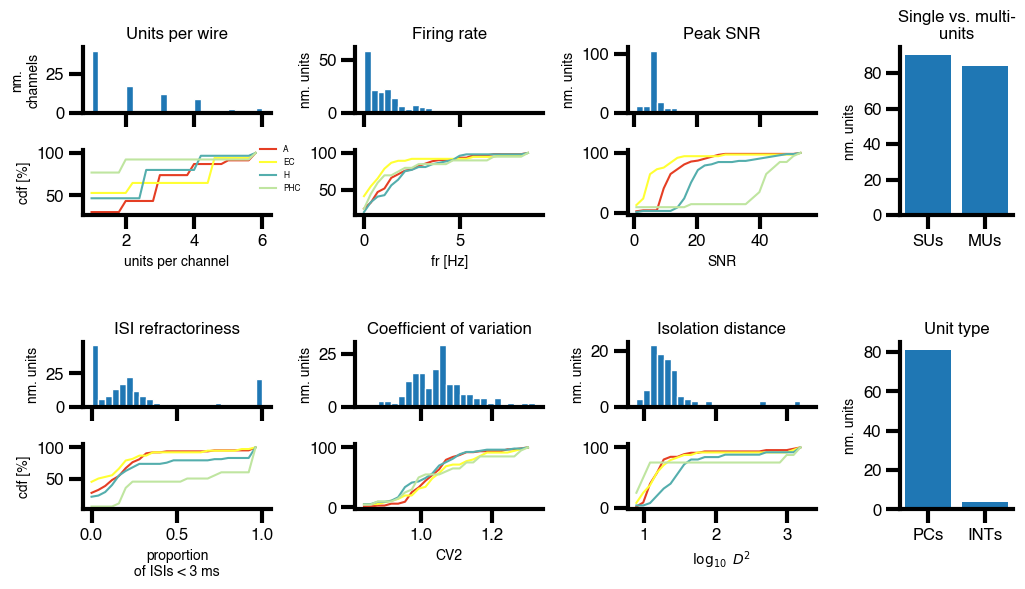

In [215]:
b = 25

fig = plt.figure(constrained_layout=False, figsize=(12, 6))
gs = fig.add_gridspec(nrows=5, ncols=4,
                       height_ratios=[1, 1, 0.8, 1, 1], 
                       width_ratios=[1, 1, 1, 0.6])

fig.subplots_adjust(hspace=0.6, wspace=0.5) 

# units per channel

ax0 = fig.add_subplot(gs[0:1, 0:1])
ax1 = fig.add_subplot(gs[1:2, 0:1], sharex=ax0)

hists, bin_edges, cdf_region_dict = data_units_per_channel(df_channelwise_units, bins=b)
plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_region_dict, )

ax0.set_title("Units per wire")
ax0.set_ylabel("nm.\nchannels")

ax1.set_xlabel("units per channel")
ax1.set_ylabel("cdf [%]")
ax1.legend(bbox_to_anchor=(.9, 1.2), 
           fontsize=6,
           markerscale=0.1,
           frameon=False)

sugar(ax0, ax1)

# firing rate
ax0 = fig.add_subplot(gs[0:1, 1:2], )
ax1 = fig.add_subplot(gs[1:2, 1:2], sharex=ax0)

hists, bin_edges = np.histogram(df_units_all["fr_hz"], b)
cdf_region_dict = cdf_regionwise_metrics(df_units_all, "fr_hz", b)
plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_region_dict, )

ax0.set_title("Firing rate")
ax0.set_ylabel("nm. units")
ax1.set_xlabel("fr [Hz]")
sugar(ax0, ax1)

# spike peak SNR
ax0 = fig.add_subplot(gs[0:1, 2:3])
ax1 = fig.add_subplot(gs[1:2, 2:3], sharex=ax0)

hists, bin_edges = no_nan_histogram(df_units_all["peak_SNR"], b)
cdf_region_dict = cdf_regionwise_metrics(df_units_all, "peak_SNR", b)
plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_region_dict, )

ax0.set_title("Peak SNR")
ax0.set_ylabel("nm. units")
ax1.set_xlabel("SNR")
sugar(ax0, ax1)

# ISI violations
ax0 = fig.add_subplot(gs[3:4, 0:1])
ax1 = fig.add_subplot(gs[4:, 0:1], sharex=ax0)

hists, bin_edges = np.histogram(df_units_all["isi_violations"], b)
cdf_region_dict = cdf_regionwise_metrics(df_units_all, "isi_violations", b)
plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_region_dict, )

ax0.set_title("ISI refractoriness")
ax0.set_ylabel("nm. units")

ax1.set_xlabel("proportion\nof ISIs < 3 ms")
ax1.set_ylabel("cdf [%]")
sugar(ax0, ax1)

# CV2
ax0 = fig.add_subplot(gs[3:4, 1:2])
ax1 = fig.add_subplot(gs[4:, 1:2], sharex=ax0)

hists, bin_edges = no_nan_histogram(df_units_all["cv2"], b)
cdf_region_dict = cdf_regionwise_metrics(df_units_all, "cv2", b)
plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_region_dict, )

ax0.set_title("Coefficient of variation")
ax0.set_ylabel("nm. units")
ax1.set_xlabel("CV2")
sugar(ax0, ax1)

# isolation distance
ax0 = fig.add_subplot(gs[3:4, 2:3])
ax1 = fig.add_subplot(gs[4:, 2:3], sharex=ax0)

df_units_all.loc[df_units_all["iso_dist"] > 1e11, "iso_dist"] = np.nan # hacky work-around for buggy filter, fix
hists, bin_edges = no_nan_histogram(np.log10(df_units_all["iso_dist"]), b)
cdf_region_dict = cdf_regionwise_metrics(df_units_all, "iso_dist", b, log=True)
plot_hist_cdf_panel(ax0, ax1, hists, bin_edges, cdf_region_dict, )

ax0.set_title("Isolation distance")
ax0.set_ylabel("nm. units")
ax1.set_xlabel(r'$\log_{10}$ $D^{2}$')
sugar(ax0, ax1)

# single-unit vs multi-units
ax0 = fig.add_subplot(gs[0:2, 3])

su, mu = count_su_mu(df_units_all)
ax0.bar([0,1], [su,mu])
ax0.set_title("Single vs. multi-\nunits")
ax0.set_xticks([0,1])
ax0.set_xticklabels(["SUs", "MUs"])
ax0.set_ylabel("nm. units")
sns.despine(ax=ax0)

# pyramidal cells vs interneurons
ax0 = fig.add_subplot(gs[3:, 3],)
pyramdials = (df_units_all["cell_type"] == "pyramidal").sum()
interneurons = (df_units_all["cell_type"] == "interneuron").sum()
ax0.bar([0,1], [pyramdials,interneurons],)
ax0.set_title("Unit type")
ax0.set_ylabel("nm. units")
ax0.set_xticks([0,1])
ax0.set_xticklabels(["PCs", "INTs"])

sns.despine(ax=ax0)

plt.show()